# Identifying Persons of Interest in the Enron Fraud

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. 

This project will be used to build a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist with this I will be using a hand-generated list of persons of interest in the fraud case, which includes individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

The Enron email and financial data have been combined into a dictionary, where each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.

**financial features:** ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

**email features:** ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

**POI label:** [‘poi’] (boolean, represented as integer)

In [1]:
import sys
import pickle
sys.path.append("/tools/")

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
with open("final_project_dataset.pkl", "r") as data_file:
    enron_data = pickle.load(data_file)
df = pd.DataFrame.from_dict(enron_data, orient='index')

## Explore the data set
Briefly explore the data set to find out what type of values we're dealing with, if tehre's a lot of missing values etc. 

In [9]:
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,NaN,2195.0,152.0,65.0,False,NaN,-3081055.0,304805.0,phillip.allen@enron.com,47.0
BADUM JAMES P,NaN,NaN,178980.0,182466.0,257817.0,NaN,NaN,NaN,NaN,257817.0,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477.0,566.0,NaN,916197.0,4046157.0,NaN,1757552.0,465.0,-560222.0,5243487.0,...,NaN,29.0,864523.0,0.0,False,NaN,-5104.0,NaN,james.bannantine@enron.com,39.0
BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,NaN,NaN,10623258.0,...,NaN,NaN,2660303.0,NaN,False,NaN,-1386055.0,1586055.0,NaN,NaN
BAY FRANKLIN R,239671.0,NaN,260455.0,827696.0,NaN,400000.0,145796.0,NaN,-82782.0,63014.0,...,NaN,NaN,69.0,NaN,False,NaN,-201641.0,NaN,frank.bay@enron.com,NaN


In [13]:
print 'Number of features:', len(df.columns)
print 'Total number of people:', df['poi'].count()
print 'Number of POIs in data set:', df.loc[df.poi == True, 'poi'].count()

count = 0
with open('poi_names.txt', 'r') as f:
    for line in f:
        if '(y)' in line or '(n)' in line:
            count += 1
print "Number of POI in poi_names.txt:", count

Number of features: 21
Total number of people: 146
Number of POIs in data set: 18
Number of POI in poi_names.txt: 35


In [36]:
# How many people in this dataset have a quantified salary? What about a known email address?

print "The number of quantified salaries is:", (df['salary'] !='NaN').sum()
print "The total number of given email addresses is:", (df['email_address'] !='NaN').sum()
print "The number of NaN payments is:", (df['total_payments'] =='NaN').sum()

The number of quantified salaries is: 95
The number of quantified email addresses is: 111
The number of NaN payments is: 21


The NaN's found in the financial data could be interpreted as 0. Looking at the insider pay document we can see that some employees have 0 listed for their bonus. Therefore I will replace the NaNs in the financial data with 0s. 

In [25]:
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
df[financial_features] = df[financial_features].fillna(0)

In [16]:
# How many POIs have NaN total payments?
counter=0
for name in enron_data.keys():
    if enron_data[name]["poi"]==1 and enron_data[name]["total_payments"] =='NaN':
      counter +=1

print counter

0


## Outliers

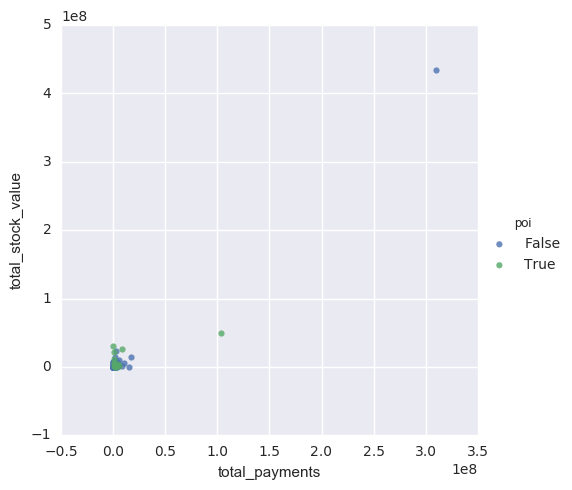

In [13]:
sns.lmplot('total_payments', 'total_stock_value', 
           data=df, 
           fit_reg=False, 
           hue='poi')


## Questions

**1. Summarize the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question.**

**Were there any outliers in the data when you got it, and how did you handle those?**  


**2. What features did you end up using in your POI identifier, and what selection process did you use to pick them?** 

**Did you have to do any scaling? Why or why not?**

**As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.)**

**In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values. ** 


**3. What algorithm did you use?** 

**What other one(s) did you try? How did model performance differ between algorithms?** 


**4. What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?**  

**How did you tune the parameters of your particular algorithm? What parameters did you tune? (Some algorithms do not have parameters that you need to tune -- if this is the case for the one you picked, identify and briefly explain how you would have done it for the model that was not your final choice or a different model that does utilize parameter tuning, e.g. a decision tree classifier).**  


**5. What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?**

**6. Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance. **

## Files included in this project:
* **poi_id.py :** Code for the POI identifier.
* **final_project_dataset.pkl :** The dataset for the project. 
* **tester.py :** Used to test the functionality of the poi_id.py file. 
* **emails_by_address :** This directory contains many text files, each of which contains all the messages to or from a particular email address. 